In [11]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load synthetic data
lalonde_exp = pd.read_csv("synthetic_exp.csv")
lalonde_obs = pd.read_csv("synthetic_observed.csv")

# Create the outcome variable
lalonde_exp["re78_re75"] = lalonde_exp["re78"] - lalonde_exp["re75"]
lalonde_obs["re78_re75"] = lalonde_obs["re78"] - lalonde_obs["re75"]


In [12]:
def bootstrap(df, function, n=50, ci=95, set_seed=True, **kwargs):
    if set_seed:
        np.random.seed(42)
    results = []

    for _ in range(n):
        new_df = df.sample(n=df.shape[0], replace=True)
        assert new_df.shape == df.shape
        results.append(function(new_df, **kwargs))

    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile

    results_arr = np.array(results)
    lower_ci = np.percentile(results_arr, lower_percentile, axis=0)
    upper_ci = np.percentile(results_arr, upper_percentile, axis=0)
    mean_ = np.mean(results_arr)

    return np.array([mean_, lower_ci, upper_ci])

def bootstrap_experiment(df, function, num_exp=10, n=50, ci=95, **kwargs):
    experiment_results = []

    for _ in tqdm(range(num_exp), desc=f"Running experiments"):
        ci_result = bootstrap(df, function, n=n, ci=ci, set_seed=False, **kwargs)
        experiment_results.append(ci_result)

    return np.array(experiment_results)


In [13]:
def backdoor_param_a(df, treatment_col, outcome_col, confounder_cols):
    formula = f"{outcome_col} ~ {treatment_col} + " + " + ".join(confounder_cols)
    model = smf.ols(formula=formula, data=df).fit()
    param_a = model.params[treatment_col]
    return param_a


Running bootstrap for strata: ['age']


Running experiments: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Running bootstrap for strata: ['age', 'education']


Running experiments: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Running bootstrap for strata: ['age', 'education', 'black']


Running experiments: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Running bootstrap for strata: ['age', 'education', 'black', 'hispanic']


Running experiments: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Running bootstrap for strata: ['age', 'education', 'black', 'hispanic', 'married']


Running experiments: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Running bootstrap for strata: ['age', 'education', 'black', 'hispanic', 'married', 're74']


Running experiments: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Running bootstrap for strata: ['age', 'education', 'black', 'hispanic', 'married', 're74', 're75']


Running experiments: 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


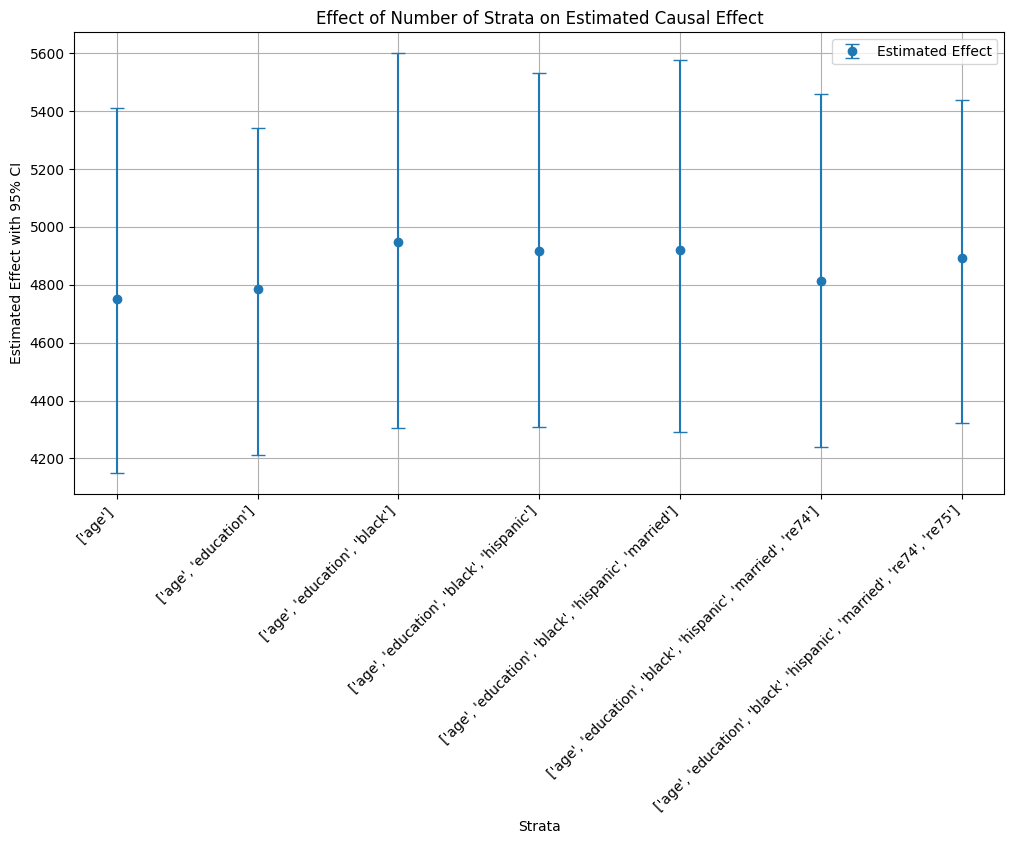

                                              strata  mean_effect  \
0                                              [age]  4752.412459   
1                                   [age, education]  4785.863234   
2                            [age, education, black]  4949.142808   
3                  [age, education, black, hispanic]  4915.482664   
4         [age, education, black, hispanic, married]  4919.514989   
5   [age, education, black, hispanic, married, re74]  4812.801198   
6  [age, education, black, hispanic, married, re7...  4891.368368   

      lower_ci     upper_ci  
0  4148.368114  5410.303234  
1  4211.050554  5342.732081  
2  4306.488251  5600.122403  
3  4309.974588  5532.768884  
4  4292.097658  5578.235523  
5  4237.935132  5459.587897  
6  4323.528636  5437.142667  


In [14]:
# Running bootstrap for different number of strata
strata_combinations = [
    ["age"],
    ["age", "education"],
    ["age", "education", "black"],
    ["age", "education", "black", "hispanic"],
    ["age", "education", "black", "hispanic", "married"],
    ["age", "education", "black", "hispanic", "married", "re74"],
    ["age", "education", "black", "hispanic", "married", "re74", "re75"]
]

results = []

for strata in strata_combinations:
    print(f"Running bootstrap for strata: {strata}")
    bootstrap_results = bootstrap_experiment(
        df=lalonde_exp,
        function=backdoor_param_a,
        num_exp=10,
        n=50,
        ci=95,
        treatment_col="treat",
        outcome_col="re78_re75",
        confounder_cols=strata,
    )
    mean_effect = np.mean(bootstrap_results[:, 0])
    lower_ci = np.mean(bootstrap_results[:, 1])
    upper_ci = np.mean(bootstrap_results[:, 2])
    results.append((strata, mean_effect, lower_ci, upper_ci))

# Convert results to DataFrame for easier visualization
results_df = pd.DataFrame(results, columns=["strata", "mean_effect", "lower_ci", "upper_ci"])




In [17]:
results_df

,strata,mean_effect,lower_ci,upper_ci
0,[age],4752.412459,4148.368114,5410.303234
1,"[age, education]",4785.863234,4211.050554,5342.732081
2,"[age, education, black]",4949.142808,4306.488251,5600.122403
3,"[age, education, black, hispanic]",4915.482664,4309.974588,5532.768884
4,"[age, education, black, hispanic, married]",4919.514989,4292.097658,5578.235523
5,"[age, education, black, hispanic, married, re74]",4812.801198,4237.935132,5459.587897
6,"[age, education, black, hispanic, married, re7...",4891.368368,4323.528636,5437.142667


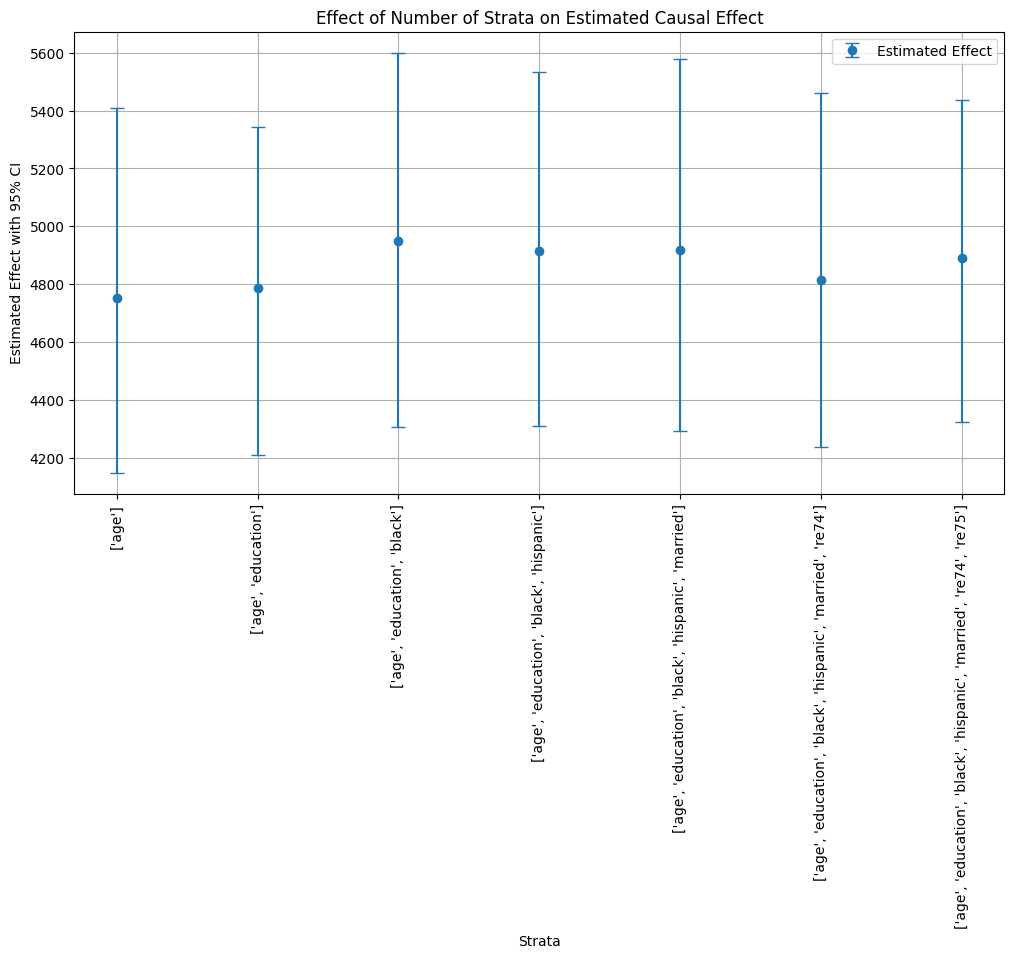

In [18]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.errorbar(
    x=range(len(results_df)),
    y=results_df["mean_effect"],
    yerr=[results_df["mean_effect"] - results_df["lower_ci"], results_df["upper_ci"] - results_df["mean_effect"]],
    fmt='o',
    capsize=5,
    label='Estimated Effect'
)
plt.xticks(range(len(results_df)), results_df["strata"], rotation=90)
# plt.xticks(range(len(results_df)), results_df["strata"], rotation=45, ha="right")
plt.xlabel("Strata")
plt.ylabel("Estimated Effect with 95% CI")
plt.title("Effect of Number of Strata on Estimated Causal Effect")
plt.grid(True)
plt.legend()
plt.show()